# Projet de MU4MA074 - Probabilités numériques et statistiques computationnelles

**Etudiants du binôme :** Sebastian Reboul (n°3711610), Amaia Cardiel (n°3310264)

**Projet n° 30 :**  Comment choisir le bon nombre de clusters, dans le cadre d'un clustering au sein d'un modèle de mélange gaussien bidimensionnel ?

In [22]:
library(repr) # pour la taille des graphiques jupyter
library('mvtnorm') # pour les densités gaussiennes bidimensionnelles

### Introduction : pourquoi un modèle de clustering via mélange gaussien ?

Une des méthodes de clustering les plus célèbres est l'algorithme k-means. Celui-ci est puissant et relativement simple à mettre en oeuvre car dépourvu de modélisation probabiliste. Il a néanmoins deux principaux défauts : 
* La forme des clusters obtenus est peu flexible (notamment, si la norme euclidienne est choisie dans les calculs de distance, ce qui est très fréquent, les clusters obtenus seront des boules euclidiennes)
* L'association des données aux clusters est qualifiée de "dure" et "déterministe" ("hard clustering") 

Le fait d'effectuer du clustering par algorithme EM au sein d'un modèle de mélange gaussien permet de pallier ces deux défauts. En effet, les gaussiennes permettent d'identifier des clusters de forme elliptique beaucoup plus complexes et le cadre probabiliste permet d'effectuer du "soft clustering" (permettant à chaque donnée de participer avec des poids différents à l'estimation de chaque cluster).

Puisque l'algorithme EM permet d'estimer l'EMV d'un nombre fini de paramètres du modèle (les proportions de chaque groupe du mélange ainsi que les paramètres de chaque gaussienne), il s'agit d'une approche dite "model based" et paramétrique. 

### 1) Présentation du modèle et des données considérées

* **Modèle de mélange gaussien bidimensionnel**

Soit $X=(X_{1},...,X_{n})$, n variables iid issues d'un modèle de mélange de C lois gaussiennes. En notant $Z =(Z_{1},...,Z_{n})$ les n variables latentes où chaque $Z_{i}$ correspond à l'étiquette de la variable $X_{i}$, on peut écrire la loi conditionnelle de $X_{i}$ et la loi de $Z_{i}$ comme suit :

$\forall i \in \{1,...,n\}$,

$\mathcal{L}(X_{i}\vert Z_{i}=j)=\mathcal{N}(\mu_{j},\, Σ_{j})$,   avec $j \in \{1,...,C\}$

$\mathbb{P}(Z_{i}=j)=\pi_{j}$,  avec $j \in \{1,...,C\}$ tel que $\sum_{j=1}^{C}\pi_{j}=1$

On peut ainsi écrire la densité f du mélange de la manière suivante : 

$f_{\theta}(x)=\sum_{j=1}^{C}\pi_{j}f_{j}(x), \ \ x \in \mathbf{R^{2}}$

avec $f_{j}$ une densité de loi normale bidimensionnelle $\mathcal{N}(\mu_{j},\, Σ_{j}) \ \ \forall j \in \{1,...,C\}$ 

L'utilisation de l'algorithme EM dans ce cadre aura pour but d'estimer le paramètre $\theta$ du modèle : 

$\theta=(\pi_{1},...,\pi_{C},\mu_{1},...,\mu_{C}, Σ_{1},...,  Σ_{C})$ où chaque $\mu_{j} \in \mathbf{R^{2}}, Σ_{j} \in M_{2,2}(\mathbf{R})$

Puisque les $\pi_{j}$ somment à 1, on peut déduire la valeur de $\pi_{C}$ à partir de $\pi_{1},...,\pi_{C-1}$.

Notre modèle a donc **k=3C-1 paramètres inconnus** (C-1 réels, C vecteurs de dimension 2 et C matrices de dimension 2x2). 

* **Simulation de données synthétiques**

Nous commençons ce projet par la simulation de données synthétiques, comme réalisations de X. Cette simulation nous permettra d'avoir accès aux étiquettes des données (la connaissance de la loi gaussienne ayant généré chaque variable).

Afin d'avoir une grande variété de modèles possibles, aisément visualisables, sans trop d'excès de complexité, nous choisissons de générer des gaussiennes bidimensionnelles dont les composantes sont indépendantes (leur matrice de covariance sont diagonales).  

La fonction suivante générera un échantillon de taille **n**, de nombre de composantes **C** (qu'on nommera souvent "clusters" par abus de langage) et de paramètres **param** laissés au choix. Elle retournera également le nombre d'étiquettes de chaque composante à travers la variable **Nb**. Notons que l'échantillon sera retourné sous la forme d'une matrice nx2 où la ligne i $\in \{1,...,n\}$ contient les coordonnées de $x_{i} \in \mathbf{R^{2}}$.

In [23]:
generate_2D<-function(n,C,param){
  
  pi = param[[1]]
  mu = param[[2]]
  sigma = param[[3]]
  
  Z=sample(size = n,x = 1:C,prob = pi,replace = TRUE) #on tire n réalisation 
  
  Nb = numeric(length = C)
  for (i in 1:C){
    Nb[i]=sum(Z==i)  
  }
    
  res = matrix(nrow = 0,ncol = 2)

  for (k in 1:C){
    M = matrix(nrow=Nb[k],ncol=2)
    # dans rnorm le dernier paramètre est l'ecart type et non la variance
    M[,1]=rnorm(Nb[k],mu[k,1],sigma[k,1]) 
    M[,2]=rnorm(Nb[k],mu[k,2],sigma[k,2])
    res = rbind(res,M)
  }

  return(list("Data"=res,"Nb" = Nb))
}

Déclarons **$\theta_{true}$** une liste de paramètres ($\pi$,$\mu$,Σ) choisis arbitrairement tels que :

* $\pi_{true}$= (0.2,0.15,0.3,0.35)
* $\mu_{true}$= (
$\begin{pmatrix}
8 \\
20
\end{pmatrix}$, 
$\begin{pmatrix}
15 \\
10
\end{pmatrix}$, 
$\begin{pmatrix}
15 \\
-1
\end{pmatrix}$,
$\begin{pmatrix}
22 \\
20
\end{pmatrix}$)
* $Σ_{true}$ = (
$\begin{pmatrix}
9 & 0\\
0 & 1
\end{pmatrix}$, 
$\begin{pmatrix}
1 & 0\\
0 & 9
\end{pmatrix}$, 
$\begin{pmatrix}
4 & 0\\
0 & 4
\end{pmatrix}$,
$\begin{pmatrix}
6.25 & 0\\
0 & 6.25
\end{pmatrix}$)

Nous pouvons alors appeler notre fonction pour générer des données issues de ce mélange gaussien.

In [24]:
C = 4 # nombre de "clusters" ou "sous-groupes" du mélange gaussien
pi = c(0.2,0.15,0.3,0.35) # proportions de données au sein de chaque groupe
mu = matrix(nrow = C,ncol = 2,data = c(8,15,15,22,20,10,-1,20)) # moyennes des gaussiennes
sigma = matrix(nrow = C,ncol = 2,data = c(3,1,2,2.5,1,3,2,2.5)) # racines des valeurs diagonales des matrices de covariance
true_theta = list(pi,mu,sigma)
n=500
set.seed(123) # on fixe la graine pour travailler à échantillon fixé
Ech=generate_2D(n,C,true_theta)
echantillon = Ech$Data # Echantillon obtenu
Nb=Ech$Nb # Nombre de données générées pour chaque cluster
print('Nombre de variables générées dans chacun des 4 sous-groupes :')
print(Nb)

[1] "Nombre de variables générées dans chacun des 4 sous-groupes :"
[1]  98  73 149 180


Visualisons les données générées sans en indiquer les étiquettes (variables Zi) :

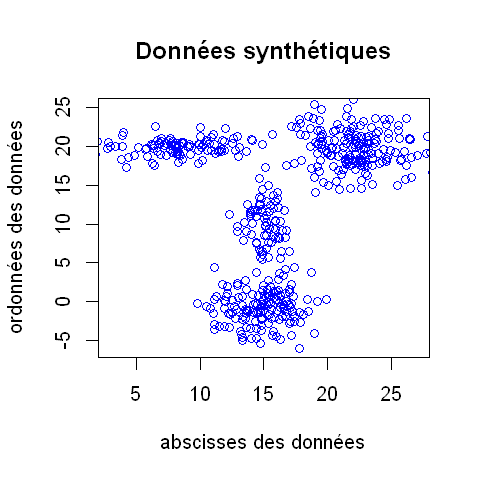

In [25]:
par(mfrow = c(1,1))
options(repr.plot.width=4, repr.plot.height=4) # permet de choisir la taille des graphiques sur jupyter notebook

# plot du nuage de points des données synthétiques (sans label)
plot(x = Ech$Data[,1], y = Ech$Data[,2], pch=1,col = "blue", xlim = c(min(mu[,1])-5,max(mu[,1])+5),ylim = c(min(mu[,2])-5,max(mu[,2])+5), main="Données synthétiques", xlab='abscisses des données', ylab='ordonnées des données')

* **Visualisation des étiquettes et de la densité réelle de l'échantillon**

Le package 'mvtnorm' nous permet d'appeler aisément la densité d'une variable gaussienne bidimensionnelle. Cela nous permet de définir une fonction qui retourne la densité de notre mélange gaussien synthétique (afin de faire un contour plot). Nous nommerons cette fonction "estimated_density" car elle nous servira plus tard à définir les densités pour des $\widehat \theta$ estimés mais dans un premier temps elle nous donnera la "vraie densité" pour le $\theta_{true}$ ayant généré l'échantillon. 

In [26]:
# mvtnorm requiert un formatage de sigma légèrement différent 
# on ne donne pas l'ecart type des valeurs diagonales mais les matrices de covariance elles-même en entier (en ligne)
sigma=matrix(c(9,1,4,6.25,0,0,0,0,0,0,0,0,1,9,4,6.25),nrow=4,ncol=4) 
true_theta = list(pi,mu,sigma)

In [27]:
estimated_density <- function(x,theta_sol){ # avec x de dimension 2 
  pi = theta_sol[[1]]
  mu = theta_sol[[2]]
  sigma = theta_sol[[3]]
  C = length(pi)
  dens=0
  for (j in 1:C){
    sigmaj=matrix(sigma[j,],ncol=2)
    dens=dens+pi[j]*dmvnorm(x, mean = mu[j,], sigma = sigmaj)
  }
  return(dens)
}

Nous définissons une fonction d'affichage qui nous permettra de représenter l'échantillon synthétique sur lequel on superpose le contour plot d'une densité (densité définie via le theta_sol passé en argument).

In [28]:
affiche_contour <- function(Ech,theta_sol,main=paste("Densité estimée pour C=",C)){ # Avec Ech, la liste retournée par la fonction generate_2D

     pi = theta_sol[[1]]
      C = length(pi)
    
    # Construction d'une matrice (pour le contour plot)
  x <- seq(min(mu[,1])-5, max(mu[,1])+5, by = 0.5)
  y <- seq(min(mu[,2])-5, max(mu[,2])+5, by = 0.5)
  DensMat<- matrix(NA, nrow = length(x), ncol = length(y))
  for (i in 1:length(x)){
    for (j in 1:length(y)){
      DensMat[i,j] <- estimated_density(c(x[i],y[j]),theta_sol)
    }
  }
  
    Nb = Ech$Nb
    n = length(Ech$Data[,1])
    
    par(mfrow = c(1,1))
    options(repr.plot.width=4, repr.plot.height=4) # permet de choisir la taille des graphiques sur jupyter notebook

    # plot des points des données synthétiques
    plot(x = Ech$Data[1:Nb[1],1], y = Ech$Data[1:Nb[1],2], pch=1,col = "green", xlim = c(min(mu[,1])-5,max(mu[,1])+5),ylim = c(min(mu[,2])-5,max(mu[,2])+5), main=main, xlab='abscisses des données', ylab='ordonnées des données')
    points(x = Ech$Data[(Nb[1]+1):(Nb[1]+Nb[2]),1], y = Ech$Data[(Nb[1]+1):(Nb[1]+Nb[2]),2], pch=1,col = "blue")
    points(x = Ech$Data[(Nb[1]+Nb[2]+1):(Nb[1]+Nb[2]+Nb[3]),1], y = Ech$Data[(Nb[1]+Nb[2]+1):(Nb[1]+Nb[2]+Nb[3]),2], pch=1,col = "orange")
    points(x = Ech$Data[(Nb[1]+Nb[2]+Nb[3]+1):n,1], y = Ech$Data[(Nb[1]+Nb[2]+Nb[3]+1):n,2], pch=1,col = "red")

    legend(23,7, legend=c("Zi=1","Zi=2","Zi=3","Zi=4"),col = c("green","blue","orange","red"), pch=20,cex=0.8,box.lty=0,y.intersp=2)
    
    # contour de la densité calculée à partir du theta_sol en argument 
    contour(x, y, DensMat, add = TRUE, nlevels=10,lwd=1, lty=7,labcex = 1.9,drawlabels = FALSE) # simple contour
}

Visualisons les données générées (avec les contours de la vraie densité sous-jacente en noir) :

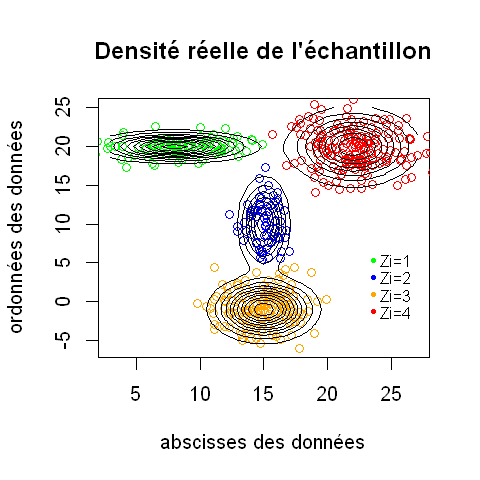

In [29]:
affiche_contour(Ech,true_theta,main="Densité réelle de l'échantillon") # avec Ech, la liste retournée par la fonction generate_2D

### 2) Algorithme EM

Cet algorithme est une procédure itérative ayant pour but d'approcher l'EMV défini comme suit : 

$\widehat \theta^{MV}=argmax_{\theta} \ l(\theta)$ 

où $l(\theta)$ est la log vraisemblance des données incomplètes, i.e. :

$l(\theta)=\sum_{i=1}^{n}log(\sum_{j=1}^{C}\pi_{j}f_{j}(x)), \ \ x \in \mathbf{R^{2}}$

Un résultat majeur du cours concernant la suite $(\theta^{(t)})_{t\geq1}$ obtenue par l'algorithme est que $l(\theta^{(t+1)})\geq l(\theta^{(t)}) \ \forall t$. Une fois codé, il s'agira de vérifier que notre algorithme présente cette propriété. C'est pourquoi nous définissons dès à présent la fonction de log vraisemblance.

**Notation** : Notons que désormais et pour le reste de ce projet, $\theta$ est une liste de 3 éléments contenant :
* en tant que premier élément le vecteur des C valeurs $\pi_{j}$, 
* en tant que second élément une matrice Cx2 contenant à la ligne j le vecteur $\mu_{j}$ de dimension 2,
* en tant que troisième élément une matrice de taille Cx4 contenant à la ligne j les éléments de la matrice 2x2 $Σ_{j}$ stockés sous forme d'un vecteur de dimension 4 ($Σ_{j,1,1}, Σ_{j,1,2},Σ_{j,2,1},Σ_{j,2,2}$).

In [30]:
logvrais = function(theta,echantillon){
  n = length(echantillon[,1])
  pi = theta[[1]]
  C = length(pi)
  if(C==1){mu = matrix(data = theta[[2]],nrow = 1,ncol = 2)}
  else{mu = theta[[2]]}
  sigma = theta[[3]]
  res=0
  for (i in 1:n){
    x = echantillon[i,]
    interieur = 0
    for (j in 1:C){
      sigmaj = matrix(data = sigma[j,],nrow = 2,ncol = 2)
      interieur = interieur + pi[j]*dmvnorm(x=x,mean = mu[j,],sigma = sigmaj)
    }
    res = res + log(interieur)
  }
  return(res)
}

#### Initialisation

Trois grands types de choix s'offrent pour l'initialisation des 3C-1 paramètres : choisir des valeurs initiales arbitraires, aléatoires ou déjà "informées" (par exemple en ayant recours à l'algorithme k-means au préalable). 

Nous ferons le choix d'une initialisation aléatoire tout en utilisant les données pour ne pas partir de données aberrantes. En effet, une bonne initialisation, en particulier des valeurs $\mu_{j}$, est déterminante pour le bon fonctionnement de l'algorithme. Ainsi, nous suivrons les recommandations vues en TP et choisirons une initialisation comme suit :

* les vecteurs $\mu_{j}$ seront initialisés à l'aide de C réalisations $x_{i}$ que nous tirerons au hasard parmi les données
* les matrices de covariance $Σ_{j}$ seront toute initialisées par la valeur de la variance empirique $s_{x}^{2}$ de l'échantillon calculée ainsi : 
$s_{x}^{2}=\frac{1}{n}\sum_{i=1}^{n}(x_{i}-\overline{x})(x_{i}-\overline{x})^{T}$
* on choisira une répartition uniforme des proportions initiales des clusters soit $\pi_{j}=\frac{1}{C} \ \ \forall j \in \{1,...,C\}$

Enfin, puisque l'algorithme peut converger vers des maxima locaux, il sera important de lancer l'algorithme EM à partir de L initialisations différentes (L=5 ou L=10 par exemple) et de choisir parmi les différentes solutions ($\widehat \theta_{1},...,\widehat \theta_{L}$) obtenues celle qui donne la plus haute valeur de log vraisemblance, i.e. $\widehat \theta=argmax \ \ l(\widehat \theta_{l}), \ l \in \{1,...,L\}$. Cette solution sera alors celle conservée comme estimateur final de $\theta$.

In [31]:
initialisation <- function(echantillon,C){
  n = length(echantillon[,1])
  #var
  xbar = colMeans(echantillon)
  M = echantillon - t(matrix(xbar,nrow = 2,ncol =n))
  sigmaj = ((t(M)%*%M)/n)
  sigma = t(matrix(data = sigmaj,nrow = 4,ncol = C))
  #mean
  mu = echantillon[sample(x = 1:n,size = C,replace = FALSE),]
  #pi
  pi = rep(x = 1/C,C)
  return(list("pi"=pi,"mu"=mu,"sigma"=sigma))
}

Voyons ce que retourne cette fonction lors de son appel :

In [13]:
set.seed(123) # on fixe la graine 
theta_0=initialisation(Ech$Data,C)
print(theta_0)

$pi
[1] 0.25 0.25 0.25 0.25

$mu
         [,1]      [,2]
[1,] 16.40405  6.441380
[2,] 22.11683 20.242261
[3,] 13.24949 -4.235548
[4,] 23.71300 23.599403

$sigma
         [,1]     [,2]     [,3]     [,4]
[1,] 30.83737 10.24646 10.24646 88.77834
[2,] 30.83737 10.24646 10.24646 88.77834
[3,] 30.83737 10.24646 10.24646 88.77834
[4,] 30.83737 10.24646 10.24646 88.77834



#### Phase itérative

* **Etape E**

A chaque itération t, l'etape E (expectation) de l'algorithme calcule la distribution de $Z_{i}$ sachant $X_{i}$ et $\theta^{(t)}$ comme suit : 

$\alpha_{i,j}:=\mathbb{P}(Z_{i}=j\vert X_{i}=x_{i},\theta^{(t)})=\frac{\pi_{j}f_{j}(x_{i})}{\sum_{j=1}^{C}\pi_{j}f_{j}(x_{i})}$

Il s'agira ensuite de calculer et maximiser la fonction Q suivante : 

$Q(\theta \vert \theta^{(t)})=\mathbb{E}_{Z\vert X,\theta^{(t)}}[log L(X,Z \vert \theta)]$

* **Etape M**

D'après le cours, l'étape M (maximisation) en $\theta$ de la fonction $Q(\theta \vert \theta^{(t)})$ donne les valeurs suivantes (au temps t+1) des $\pi_{j},\mu_{j}$ et $Σ_{j} \  \forall j \in \{1,...,C\}$ :

$\pi_{j}^{(t+1)}=\frac{1}{n}\sum_{i=1}^{n}\alpha_{i,j}$

$\mu_{j}^{(t+1)}=\frac{\sum_{i=1}^{n}\alpha_{i,j}x_{i}}{\sum_{i=1}^{n}\alpha_{i,j}}$

$Σ_{j}^{(t+1)}=\frac{\sum_{i=1}^{n}\alpha_{i,j}(x_{i}-\mu_{j}^{(t+1)})(x_{i}-\mu_{j}^{(t+1)})^{T}}{\sum_{i=1}^{n}\alpha_{i,j}}$

On définira tout d'abord la fonction update_theta permettant de passer de $\theta^{(t)}$ à $\theta^{(t+1)}$ selon les formules ci-dessus :

In [32]:
update_theta <- function(echantillon,theta){
  n = length(echantillon[,1])
  pi = theta[[1]]
  C = length(pi)
  if(C==1){mu = matrix(data = theta[[2]],nrow = 1,ncol = 2)}
  else{mu = theta[[2]]}
  sigma = theta[[3]]
  alpha = matrix(nrow = n,ncol = C)
  #alphaij
  for (i in 1:n){
    for (j in 1:C){
      denominateur = 0
      for (k in 1:C){
        sigmak = matrix(data = sigma[k,],nrow = 2,ncol = 2)
        denominateur= denominateur + pi[k]*dmvnorm(x=echantillon[i,],mean = mu[k,],sigma = sigmak)
          }
      sigmaj = matrix(data = sigma[j,],nrow = 2,ncol = 2)
      alpha[i,j]=(pi[j]*dmvnorm(x=echantillon[i,],mean = mu[j,],sigma = sigmaj))/(denominateur)
      }
  }
  newpi = colMeans(alpha)
  newmu = (t(alpha)%*%echantillon)/(colSums(alpha))
  newsigma = matrix(nrow = C,ncol = 4)
  for (j in 1:C){
    M = echantillon - t(matrix(newmu[j,],nrow = 2,ncol =n))
    sigmaj = (t(M)%*%(M*(alpha[,j])))/sum(alpha[,j])
    newsigma[j,] = c(sigmaj)
  }
  return(list(newpi,newmu,newsigma))
}

* **Etude empirique de l'évolution de la logvraisemblance**

L'appel successif de cette fonction de mise à jour et de notre fonction de logvraisemblance nous permet de vérifier dès à présent (de manière empirique) que notre algorithme permet bien de générer une suite $(\theta^{(t)})_{t\geq1}$ telle que $l(\theta^{(t+1)})\geq l(\theta^{(t)}) \ \forall t$. Pour cela traçons la vraisemblance en fonction du nombre d'itérations.

In [33]:
set.seed(123) # on fixe la graine 
theta=initialisation(echantillon,C)
logv=c(logvrais(theta,echantillon))
for (t in 1:30){
  theta = update_theta(echantillon = echantillon,theta=theta)
  logv = c(logv,logvrais(theta,echantillon))
}

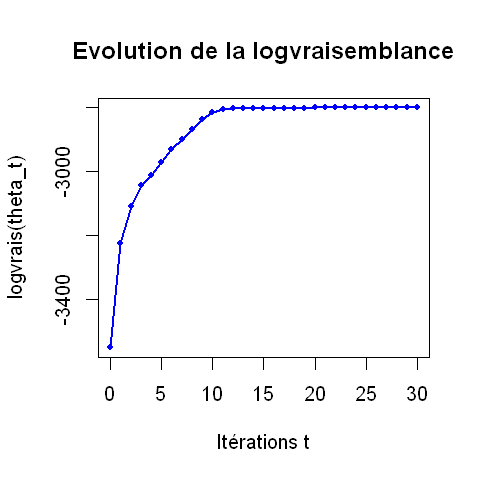

In [34]:
plot(x=0:30,y=logv, t='l', lwd = 2, main="Evolution de la logvraisemblance",col="blue", xlab='Itérations t', ylab='logvrais(theta_t)')
points(x=0:30,y=logv,pch=20,col='blue')

Nous constatons que la logvraisemblance augmente bien après chaque mise à jour de $\theta^{(t)}$, ce que nous souhaitions vérifier empiriquement.
Notons également que le plus grand gain semble avoir été réalisé dès les premières mises à jour.
Enfin, il semble que l'algorithme ait convergé dès t=12. 

* **Code de l'algorithme intégral**

Nous pouvons enfin regrouper toutes nos fonctions auxiliaires au sein d'une même fonction générant l'intégralité de l'algorithme. Celui-ci calcule pour L initialisations aléatoires différentes les valeurs $\widehat \theta_{1},...,\widehat \theta_{L}$ puis retourne celle qui maximise la logvraisemblance. 

In [35]:
algo_EM <- function(L,maxiter,echantillon,C,seuil){
  
  listtheta = list()
  listlog = c()
  
  for (iteration in 1:L){
    oldtheta = initialisation(echantillon,C)
    oldlog = logvrais(oldtheta,echantillon = echantillon)
    critère = TRUE
    iter = 0
    
    while((critère)&&(iter < maxiter)){ 
      
      newtheta = update_theta(echantillon = echantillon,theta=oldtheta)
      newlog = logvrais(newtheta,echantillon = echantillon)
      
      iter = iter +1
      critère = (abs(oldlog - newlog)>seuil)
      
      oldlog = newlog
      oldtheta = newtheta
    }
    listtheta = append(listtheta,list(newtheta))
    listlog = c(listlog,newlog)
  }
  n = which.max(x = listlog)
  return(listtheta[[n]])
}

Comparons $\widehat \theta_{test}$, une valeur estimée par l'algorithme, à la vraie valeur $\theta_{true}$ que nous avons utilisée pour générer nos données.

Pour rappel, $\theta_{true}$ était tel que : 


* $\pi_{true}$= (0.2,0.15,0.3,0.35)
* $\mu_{true}$= (
$\begin{pmatrix}
8 \\
20
\end{pmatrix}$, 
$\begin{pmatrix}
15 \\
10
\end{pmatrix}$, 
$\begin{pmatrix}
15 \\
-1
\end{pmatrix}$,
$\begin{pmatrix}
22 \\
20
\end{pmatrix}$)
* $Σ_{true}$ = (
$\begin{pmatrix}
9 & 0\\
0 & 1
\end{pmatrix}$, 
$\begin{pmatrix}
1 & 0\\
0 & 9
\end{pmatrix}$, 
$\begin{pmatrix}
4 & 0\\
0 & 4
\end{pmatrix}$,
$\begin{pmatrix}
6.25 & 0\\
0 & 6.25
\end{pmatrix}$)

In [87]:
set.seed(123) # on fixe la graine pour obtenir un theta_test "fixé" (pour que le commentaire qui suit reste pertinent)
theta_test=algo_EM(L=5,maxiter=40,echantillon=echantillon,C=C,seuil=0.05)

In [88]:
theta_test

[[1]]
[1] 0.1471051 0.2961745 0.1967555 0.3599649

[[2]]
          [,1]       [,2]
[1,] 15.110964  9.9146145
[2,] 14.844885 -0.8231598
[3,]  8.456387 19.9493750
[4,] 22.162838 19.8548747

[[3]]
          [,1]       [,2]       [,3]     [,4]
[1,] 0.9694506 -0.4330062 -0.4330062 7.768749
[2,] 4.0276105  0.2104817  0.2104817 4.444426
[3,] 9.1059883  0.5522650  0.5522650 1.029485
[4,] 6.6639132 -0.2002497 -0.2002497 6.154034

On remarque que cette estimation semble très satisfaisante si l'on considère que les résultats obtenus le sont à permutation près concernant la numérotation des sous-groupes distingués.
En effet on observe que :
* le premier groupe identifié par $\widehat \theta_{test}$ correspond au deuxième groupe (Zi=2) selon $\theta_{true}$,

* le deuxième groupe identifié par $\widehat \theta_{test}$ correspond au troisième groupe (Zi=3) selon $\theta_{true}$,

* le troisième groupe identifié par $\widehat \theta_{test}$ correspond au premier groupe (Zi=1) selon $\theta_{true}$,

* le quatrième groupe identifié par $\widehat \theta_{test}$ correspond bien au dernier groupe (Zi=4) selon $\theta_{true}$.

Ce constat illustre le phénomène du **"label switching"** : l'algorithme a produit une estimation satisfaisante des paramètres mais ne les a tout simplement pas numérotés dans le même ordre que les paramètres réels sous-jacents. 
Les résultats ne sont pas invalidés pour autant mais il faut rester vigilant et prendre ce phénomène en compte lors de l'analyse des résultats obtenus.

Superposons au graphique de notre échantillon initial celui du contour plot de la densité obtenue pour le $\widehat \theta_{test}$ estimé.

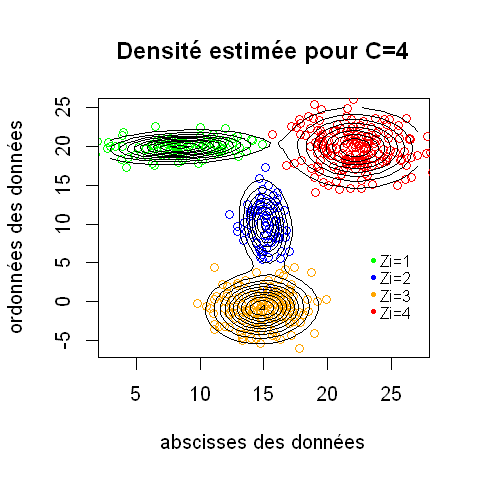

In [89]:
affiche_contour(Ech,theta_test,main="Densité estimée pour C=4") # Avec Ech, la liste retournée par la fonction generate_2D pour notre échantillon

### 3) Choix du nombre de clusters optimal

* **Critères AIC (Akaike information criterion) et BIC (Bayesian Information Criterion)**

Une méthode classique pour choisir le nombre "optimal" de cluster est de calculer les critères AIC et/ou BIC et de choisir le nombre de clusters qui minimise ces derniers. 

Formules des deux critères :
* AIC = 2k - log($\widehat L$)
* BIC = klog(n) - 2log($\widehat L$)

Avec : 
* k : nombre de paramètres du modèle (ici, k=3C-1, comme calculé en Partie 1)

* n : nombre de données considérées (ici, n est la taille de notre échantillon synthétique)

* $log(\widehat L)=log(L(\widehat \theta))=l(\widehat \theta)$ : logvraisemblance évaluée en le "meilleur" estimateur de $\theta$ (pour plusieurs initialisations)

Ces deux critères ont pour but d'estimer le degré d'ajustement aux données pour un modèle spécifique (via la vraisemblance), tout en "pénalisant" le calcul via le nombre de paramètres (et donc de clusters) utilisés. Ces critères ont ainsi pour but d'éviter le surapprentissage ("overfit") par rapport aux données puisque les modèles les plus complexes seront les plus pénalisés. Ces critères indiquent donc de choisir le nombre de clusters qui effectue le meilleur compromis entre l'ajustement aux données et la complexité de la modélisation. 

N.B. : On notera que le critère AIC ne pénalise qu'en fonction du nombre de paramètres (k) quand le critère BIC prend également en compte la taille de l'échantillon considéré (n) afin d'estimer la pertinence des modèles. 

In [36]:
AIC<-function(theta_sol,echantillon){
  pi=theta_sol[[1]]
  C = length(pi)
  k=3*C-1
  L=logvrais(theta_sol,echantillon)
  return(2*k-L)
}

In [37]:
BIC<-function(theta_sol,echantillon){
  n=length(echantillon[,1])
  pi=theta_sol[[1]]
  C = length(pi)
  k=3*C-1
  L=logvrais(theta_sol,echantillon)
  return(k*log(n)-2*L)
}

* **AIC et BIC en fonction du nombre de clusters pour notre échantillon**

Stockons les valeurs de BIC et AIC obtenues pour notre échantillon en fonction de différents nombres de clusters (de 1 à 8) :

In [38]:
set.seed(123) # on fixe la graine
listtheta = list()
BIClist = c()
AIClist = c()
for (k in 1:8){
  theta_sol = algo_EM(L = 5,maxiter = 50,echantillon = echantillon,C = k,seuil = 0.05)
  listtheta = append(listtheta,list(theta_sol))
  BIClist = c(BIClist,BIC(theta_sol,echantillon))
  AIClist = c(AIClist,AIC(theta_sol,echantillon))
}

Affichons les résultats (valeurs AIC et BIC ainsi que les $\widehat \theta$ obtenus pour les différents nombres de clusters considérés) :

In [41]:
print("Liste des valeurs AIC obtenues")
print(AIClist)
print("Liste des valeurs BIC obtenues")
print(BIClist)

[1] "Liste des valeurs AIC obtenues"
[1] 3391.880 3020.466 2899.791 2824.321 2826.475 2827.908 2795.832 2833.734
[1] "Liste des valeurs BIC obtenues"
[1] 6788.189 6052.005 5817.298 5673.002 5683.954 5693.465 5635.956 5718.404


In [42]:
for (k in 1:8){
    print(paste("theta_sol estimé pour un nombre de cluster C = ",k))
    print(listtheta[[k]])
}

[1] "theta_sol estimé pour un nombre de cluster C =  1"
[[1]]
[1] 1

[[2]]
         [,1]    [,2]
[1,] 16.26126 12.2869

[[3]]
         [,1]     [,2]     [,3]     [,4]
[1,] 30.83737 10.24646 10.24646 88.77834

[1] "theta_sol estimé pour un nombre de cluster C =  2"
[[1]]
[1] 0.5601062 0.4398938

[[2]]
         [,1]      [,2]
[1,] 17.29695 19.861872
[2,] 14.94254  2.641868

[[3]]
          [,1]       [,2]       [,3]      [,4]
[1,] 50.183972 -0.1289976 -0.1289976  4.438309
[2,]  3.098997  0.7489021  0.7489021 30.079001

[1] "theta_sol estimé pour un nombre de cluster C =  3"
[[1]]
[1] 0.3583774 0.4452424 0.1963802

[[2]]
          [,1]     [,2]
[1,] 22.180457 19.86747
[2,] 14.943571  2.80570
[3,]  8.446749 19.94920

[[3]]
         [,1]       [,2]       [,3]      [,4]
[1,] 6.616265 -0.2383677 -0.2383677  6.118881
[2,] 3.061203  0.7613386  0.7613386 31.971874
[3,] 9.071668  0.5516193  0.5516193  1.029354

[1] "theta_sol estimé pour un nombre de cluster C =  4"
[[1]]
[1] 0.1967585 0.2963531 

Voyons graphiquement les résultats obtenus :

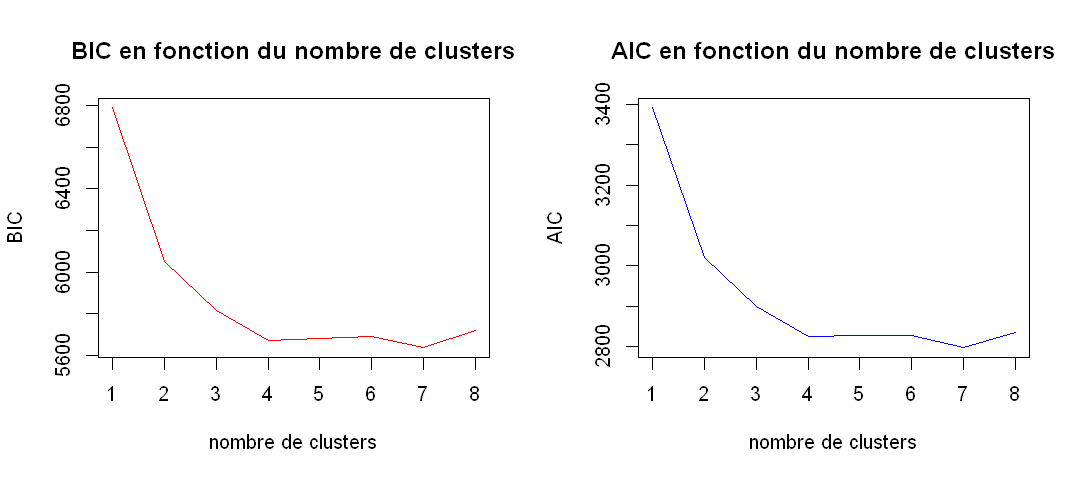

In [43]:
options(repr.plot.width=9, repr.plot.height=4) # permet de choisir la taille des graphiques sur jupyter notebook
par(mfrow = c(1,2))
abscisse=1:8
plot(x = abscisse,y = BIClist,type = 'l',col = "red", xlab = "nombre de clusters",ylab="BIC",main = "BIC en fonction du nombre de clusters")
plot(x = abscisse,y = AIClist,type = 'l',col = 'blue',xlab = "nombre de clusters",ylab="AIC",main = "AIC en fonction du nombre de clusters")

* $C \in \{1,2,3\}$ et problème de sous-ajustement aux données :

On constate que pour $C \in \{1,2,3\}$, les critères BIC et AIC sont beaucoup plus hauts que pour les valeurs suivantes ($C \in \{4,...,8\}$,).
Ce résultat était attendu puisque le nombre sous-jacent de composantes gaussiennes se trouve être C=4, ce qui fait que tout modèle ayant moins de paramètres souffre de sous-ajustement aux données ("underfiting"). On parle aussi de problème de biais, ce qui se traduit visuellement dans nos graphiques. 

* $C \in \{5,...,8\}$ et problème de sur-ajustement aux données :

On constate également que pour $C \in \{4,...,8\}$, les critères BIC et AIC restent presque constants. Cela traduit le fait que rajouter de la complexité au modèle ne peut que permettre de mieux correspondre aux données. Cela peut être expliqué par le fait que les modèles de mélange sont "emboités" : on peut toujours exprimer un mélange à x composantes via un mélange à (x+1) composantes. C'est pourquoi on ne perd rien du point de vue de la vraisemblance obtenue en ajoutant plus de clusters que nécessaire. En revanche, on pouvait espérer que les critères BIC et AIC pénalise davantage les modèles plus complexes ($C \in \{5,...,8\}$ ) que le modèle sous-jacent. En effet, un résultat idéal aurait montré que les critères BIC et AIC ont des valeurs qui réaugmentent à partir de C=5. Ici, la pénalisation n'a pas suffi à faire augmenter la valeur des critères pour ces valeurs. 

Néanmoins, un analyste confronté à notre jeu de données sans en connaitre la loi sous-jacente et ayant recours à l'analyse AIC / BIC en concluerait probablement que C=4 semble réaliser le meilleur compromis biais-variance. En effet, C=4 est le plus petit nombre de clusters permettant d'obtenir les niveaux (approximativement) minimaux des deux critères. 
Il sera préféré à un nombre supérieur de clusters (C>4) puisque ces derniers sont plus prônes au surapprentissage et sont plus complexes sans obtenir de meilleur résultat AIC / BIC. 

* **Affichons les densités estimées pour un nombre de clusters C variant de 1 à 8**

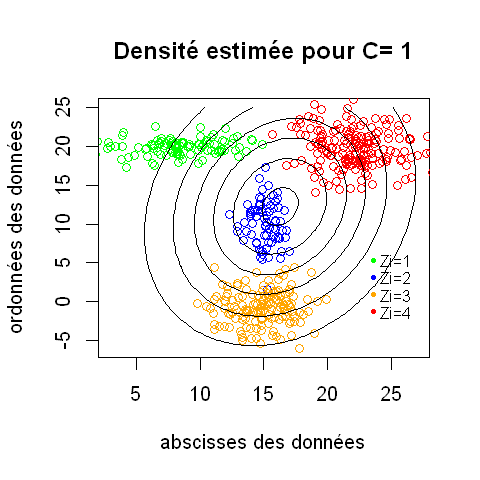

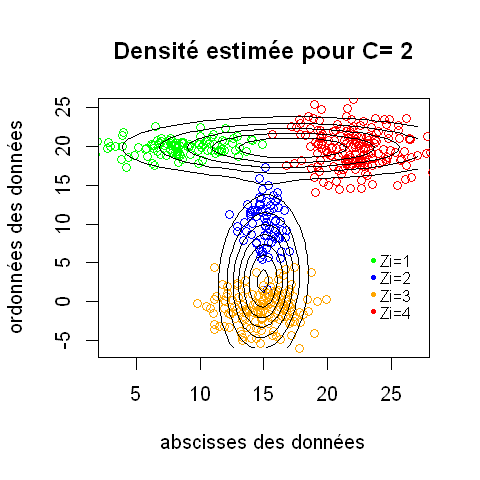

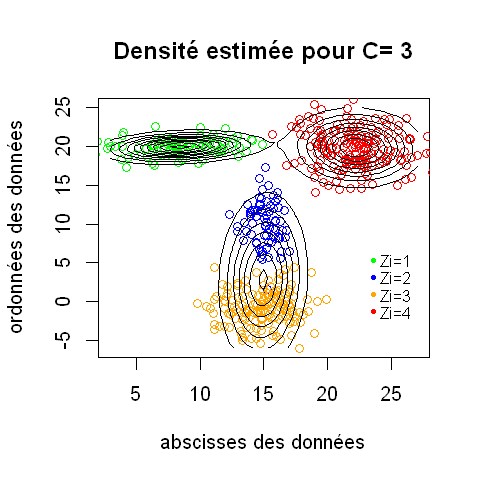

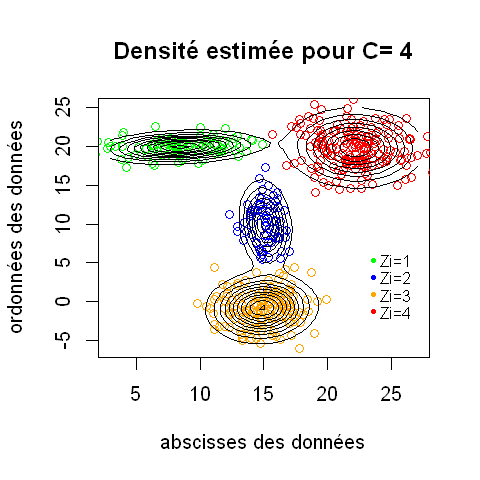

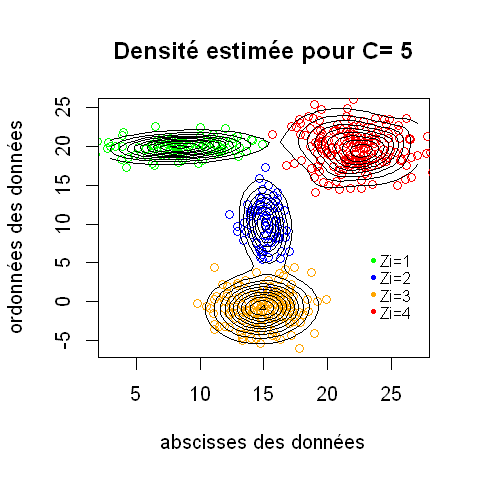

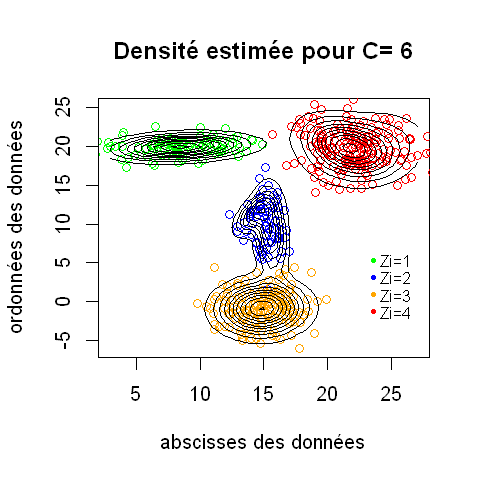

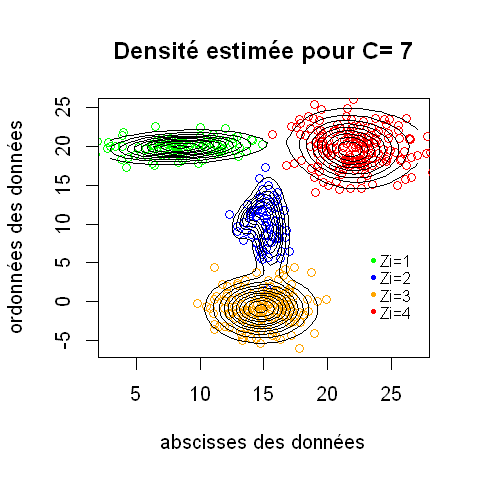

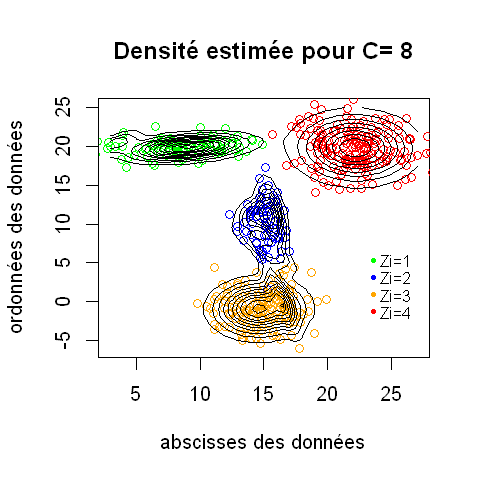

In [44]:
for (k in 1:8){
    affiche_contour(Ech,listtheta[[k]])
}

Les graphiques obtenus semblent renforcer les constats effectués sur la base des critères AIC / BIC. 
En effet, il est clair que les modèles pour $C \in \{1,2,3\}$ perdent en pertinence de par le fait qu'ils aient un nombre de clusters insuffisants pour épouser au mieux les données : on constate que certains sous-groupes sont ainsi réunis ensemble. 

Pour C=4, le graphique obtenu est visuellement très proche de celui obtenu en Partie 1 à l'aide de la densité sous-jacente réelle.

Pour $C \in \{5,...,8\}$, il *semble* que la segmentation en sous-groupes additionnels n'apporte que peu d'information supplémentaire : certains des sous-groupes identifiés pour C=4 sont scindés en plusieurs autres mais on observe que ces nouveaux sous groupes identifiés deviennent difficilement discernables à l'oeil humain. Les clusters supplémentaires permettent donc de complexifier les formes des densités obtenues ce qui amène à plus de variance dans la modélisation (cela est particulièrement visible pour C=7 et 8).

### Conclusion 

Dans ce projet, nous nous sommes concentrés sur la présentation des critères BIC et AIC, qui constituent un des outils majeurs concernant le choix du nombre de clusters au sein des algorithmes non supervisés. 
Notre échantillon synthétique aura permis d'illustrer la pertinence de ces critères en montrant que le "coude" obtenu sur les graphiques BIC / AIC (lorsque la courbe cesse de diminuer) peut permettre de choisir empiriquement un nombre pertinent de clusters. 

Notons que nous n'avons pas montré de résultats théoriques assurant la pertinence de ces critères mais que nous avons simplement voulu les illustrer empiriquement. Au-delà de la pertinence des critères présentés, nous remarquerons que cette méthode est relativement lourde à mettre en place puisqu'il faut calculer une solution par nombre de clusters exploré (dans notre cas 8). 

Remarquons également que d'autres méthodes existent en statistique afin de motiver le choix du nombre de clusters, comme par exemple le "Silhouette Score" ayant pour but d'estimer à quel point les clusters obtenus sont compacts et bien séparés. On peut également mentionner les approches dites de classification hiérarchique ascendante ou descendante (qui sont, elles aussi, lourdes et algorithmiquement complexes). 

Etudier ces autres méthodes et comparer leurs résultats à ceux obtenus par BIC / AIC pourrait ainsi constituer une piste d'approfondissement de l'analyse effectuée dans le cadre de ce projet.